In [1]:
!pip install shap

     |████████████████████████████████| 371 kB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509232 sha256=fcc01b3101c4ae754657c47c3b1bf27a3aa83105c2ce86df68d1b98668cd33d4
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [39]:
path = '/gdrive/MyDrive/app/'

In [40]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np

df = pd.read_csv(path + 'Surveillance.csv', ',')
df.head(10)

,A01,A02,A03,A04,A05,A06,A07,Categories
0,+,+,+,+,+,-,-,PUS
1,+,+,-,+,+,-,-,PUS
2,+,+,+,+,-,+,-,PUS
3,+,+,-,+,-,+,-,PUS
4,+,-,-,-,-,-,+,PUS
5,+,+,+,-,-,-,+,PUS
6,+,+,-,-,-,-,+,PUS
7,+,+,+,+,-,-,-,PUS
8,+,-,-,+,+,-,-,PIM
9,-,+,-,+,+,-,-,PIM


Датасет описывает собранные симптомы (A01 - A07) и рекомендации по действиям (Categories):

PUS - Пациента под наблюдением

PIM - Пациента на мониторинг

PWS - Пациент без опасных симптомов

In [52]:
df.columns.tolist()

['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'Categories']

In [53]:
df['Categories'].unique()

array(['PUS', 'PIM', 'PWS'], dtype=object)

In [54]:
list_name = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07']
for name in list_name:
  df.loc[(df[name] == '+') , name] = 1
  df.loc[(df[name] == '-') , name] = 0
  df[name] = df[name].astype(np.int8)

df.loc[(df['Categories'] == 'PUS') , 'Categories'] = 0
df.loc[(df['Categories'] == 'PIM') , 'Categories'] = 1
df.loc[(df['Categories'] == 'PWS') , 'Categories'] = 2

In [55]:
df.head(10)

,A01,A02,A03,A04,A05,A06,A07,Categories
0,1,1,1,1,1,0,0,0
1,1,1,0,1,1,0,0,0
2,1,1,1,1,0,1,0,0
3,1,1,0,1,0,1,0,0
4,1,0,0,0,0,0,1,0
5,1,1,1,0,0,0,1,0
6,1,1,0,0,0,0,1,0
7,1,1,1,1,0,0,0,0
8,1,0,0,1,1,0,0,1
9,0,1,0,1,1,0,0,1


In [56]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [57]:
features = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07']

In [58]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Categories'], random_state=0)

In [59]:
model = xgboost.train(  {"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# строим модель объЯсненияе в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer( model)
shap_values = explainer.shap_values(X_train)

# покажем объяснение первого примера (берем matplotlib=True для обхода Javascript)
shap.initjs() # для работы в колаборатории 
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [62]:
n=8
shap.initjs() # для работы в колаборатории 
shap.force_plot(explainer.expected_value, shap_values[n,:], X_train.iloc[n,:])

In [63]:
shap_values[0,:]

array([-0.17406397, -0.07375008,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ], dtype=float32)

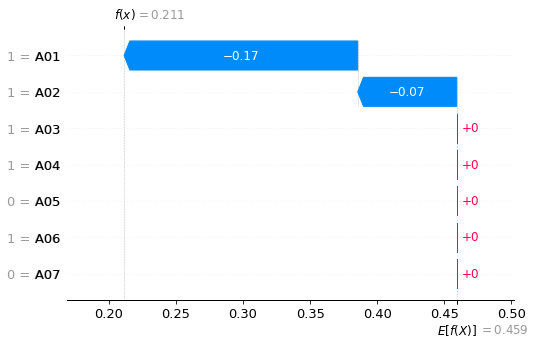

In [64]:
shap_values_all = explainer(X_train.iloc[:1000,:])

shap.initjs() # для работы в колаборатории 
shap.plots.waterfall(shap_values_all[0])

In [65]:
exp_sh=explainer.shap_interaction_values(X_train)

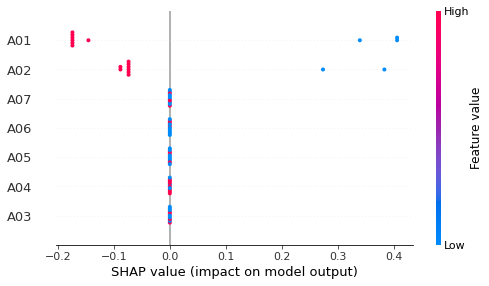

In [66]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

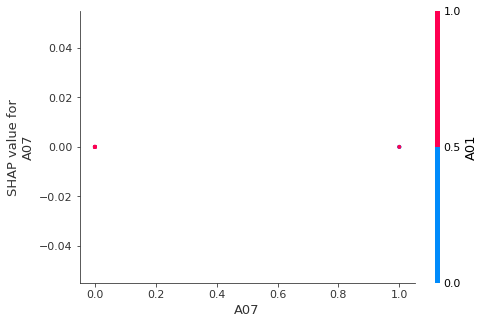

In [68]:
shap.dependence_plot("A07", shap_values, X_train)
#shap.dependence_plot("yr_built", shap_values, X_train)

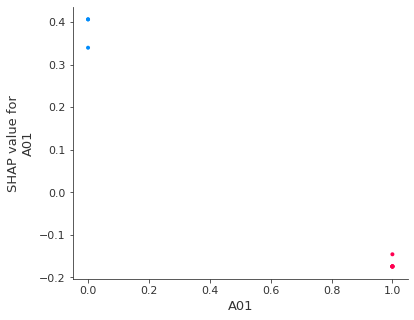

In [71]:
shap.dependence_plot("A01", shap_values, X_train)

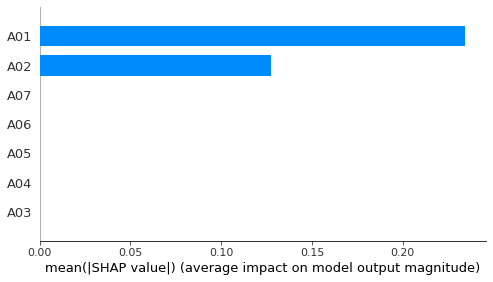

In [72]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

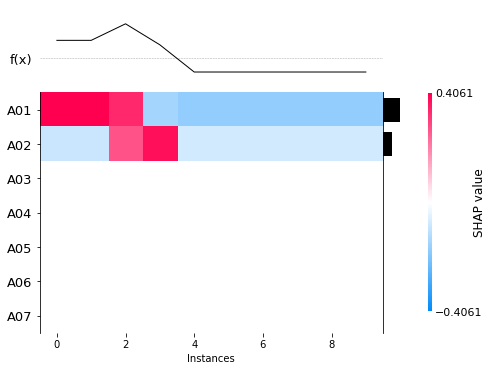

In [73]:
shap.initjs() # для работы в колаборатории 

shap.plots.heatmap(shap_values_all)

In [74]:
n = 40
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[:n,:], X_train.iloc[:n,:])

Основные симптомы A01 и A02

1. Fever or history of fever (A01).
2. Symptoms and signs of respiratory distress(cough, cold, sore throat, etc.) (A02).

1. Лихорадка или лихорадка в анамнезе (A01).
2. Симптомы и признаки респираторной недостаточности (кашель, простуда, боль в горле и т. Д.) (A02).